---

<h1><center> Probability thresholds and the ROC curve </center></h1>

---

We will plot the ROC curve for a logistic regression classifier. We will also select probability thresholds for maximizing accuracy and minimizing cost. The problem is based on the "Iris dataset", which is provided with scikit-learn. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['red', 'green'])
%matplotlib notebook

# Load the data

We will begin by importing the data using `load_iris`. This returns a dictionary with several useful entries, including the feature and target data. The full dataset has 150 samples, with 4 features, and 3 classes of iris flower (the target). We will work with only two features (columns 1 and 2) and two classes (0 and 1). The code below removes the unwanted rows and columns from X and y.

In [2]:
from sklearn import datasets
from sklearn.preprocessing import LabelBinarizer

iris = datasets.load_iris()
keeprows = [target in [1,2] for target in iris.target]
X = iris.data[keeprows,:]
y = LabelBinarizer().fit_transform(iris.target[keeprows])
y = y[:,0]
X = X[:,:2]

# 1. Split the data into training and testing

Use `train_test_split` to split `X` and `y` into training and testing datasets. 20% of the data should be kept for testing.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# 2. Build a logistic regression pipeline

First, we reate a pipeline model with a standard scaler and a logistic regression classifier. Then, we train the model parameters. 

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

model = model.fit(X_train, y_train)

# 3. Extract $\theta_0$ and $\theta$ from the trained logistic regression model

We will extract the logistic regression coefficients -- $\theta_0$ and $\theta$ from the model. $\theta_0$ should be a scalar, and $\theta$ should be an array of shape `(2,)`. 

In [5]:
theta0 = model.named_steps['logreg'].intercept_[0]
theta = model.named_steps['logreg'].coef_[0]

The plot below shows the test data along with the linear decision boundary and its gradient ($\theta$). 

<IPython.core.display.Javascript object>


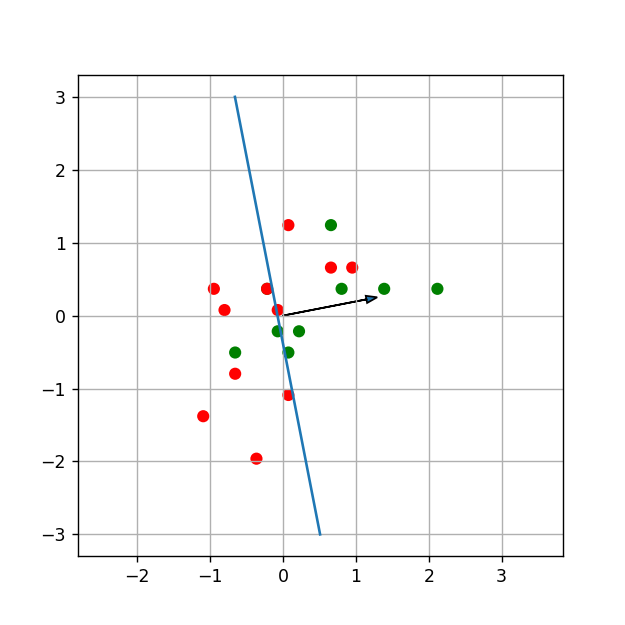

In [6]:
Xtest_scaled = model.named_steps['scaler'].transform(X_test)

x2 = np.linspace(-3, 3)
x1 = - (theta0 + theta[1] * x2)/theta[0]

plt.figure(figsize = (5, 5))

plt.scatter(Xtest_scaled[:, 0], Xtest_scaled[:, 1], c = y_test, cmap = cmap)
plt.plot(x1, x2)
plt.arrow(0, 0, theta[0], theta[1], head_width = .1)

plt.axis('equal')
plt.grid()

plt.show()

# 4. Compute the test accuracy

We will use the model to make predictions for the test data, and store those predictions in `yhat`. Then we will use scikit-learn's `accuracy_score` method to estimate the accuracy of the model. 

In [7]:
from sklearn.metrics import accuracy_score

yhat = model.predict(X_test)
test_acc = accuracy_score(y_test, yhat)

# 5. Compute the prediction probabilities

We will use the model's `predict_proba` method to estimate class probabilities for the test data points. Store the $p(Y=1|X=x)$ in yhat_proba.

In [8]:
yhat_proba = model.predict_proba(X_test)[:, 1]

The plot below shows these probabilities in a 3D projection. 

<IPython.core.display.Javascript object>


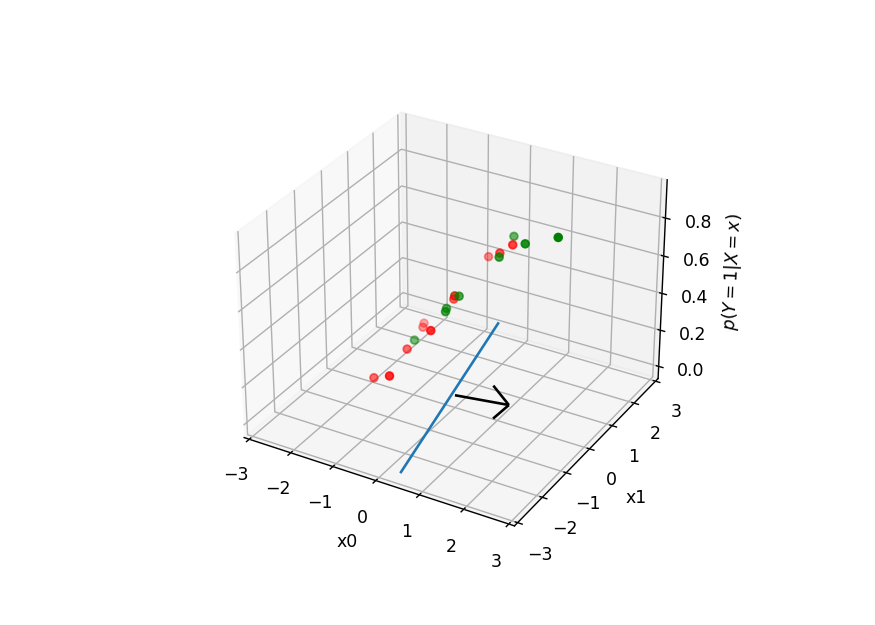

In [9]:
plt.figure(figsize = (7, 5))
ax = plt.axes(projection = '3d')

ax.scatter3D(Xtest_scaled[:, 0], Xtest_scaled[:, 1], yhat_proba, c = y_test, cmap = cmap)
ax.plot(x1, x2, 0 * x1)
ax.quiver(0, 0, 0, theta[0], theta[1], 0, color = 'black')

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel(r'$p(Y=1|X=x)$')

plt.show()

# 6. Use scikit-learn to plot the ROC curve

<IPython.core.display.Javascript object>


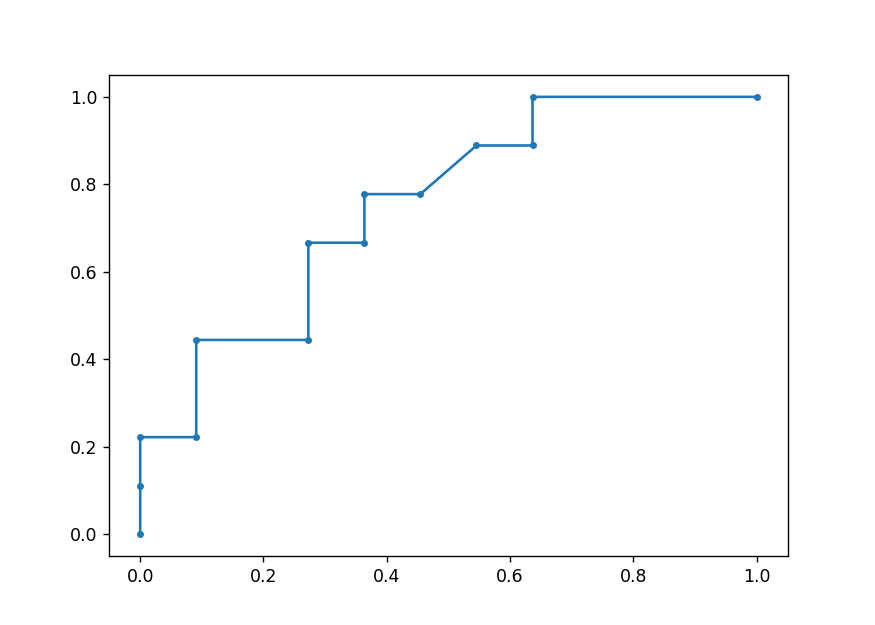

In [10]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, yhat_proba)

plt.figure(figsize = (7, 5))
plt.plot(fpr, tpr, '.-')

plt.show()

# 7. Compute performance metrics

In [11]:
N = len(y_test)

TPR = np.empty(N)
TNR = np.empty(N)
A = np.empty(N)
Cost = np.empty(N)

`Cost` will be computed assuming that a false positive is 5 times more costly than a false negative, and that there is zero profit associated with true positives and true negatives. 

In [12]:
alphaFP = 5
alphaFN = 1

The next cell sorts the probbility scores of the test samples from lowest to highest. That is, from least to most likely to belong to class 1. 

In [13]:
Rho = yhat_proba.copy()
Rho.sort()

For each probability threshold rho in Rho, we will compute the performance metrics (`TPR`, `TNR`, `A`, and `Cost`) with the decision boundary threshold set at rho. 

We will use the formula:
$$
\hat{y}=
\begin{cases}
  1, & p(Y=1|x)\geq\rho \\
  0, & otherwise
\end{cases}
$$

In [14]:
for i, rho in enumerate(Rho):
    
    # compute the positive and negative predictions using rho as the threshold
    ypred = np.empty(N)
    for j in range(len(ypred)): 
        
        if yhat_proba[j] >= rho: 
            ypred[j] = 1   
        else:
            ypred[j] = 0

    # Confusion matrix
    TP = sum( (ypred == 1) & (y_test == 1) )
    FP = sum( (ypred == 1) & (y_test == 0) )
    TN = sum( (ypred == 0) & (y_test == 0) )
    FN = sum( (ypred == 0) & (y_test == 1) )
    
    # Performance metrics
    TPR[i] = TP / (TP + FN)
    TNR[i] = TN / (TN + FP)
    A[i] = (TP + TN) / N
    Cost[i] = FP * alphaFP + FN * alphaFN

# 8. Best threshold for accuracy

Report the optimal accuracy and its corresponding probability threshold value.

In [15]:
best_A = np.argmax(A)
rhoA = Rho[best_A]
Abest = A[best_A]

# 9. Plot

Plot the accuracy vs threshold curve and indicate the optimal point with a marker. 

<IPython.core.display.Javascript object>


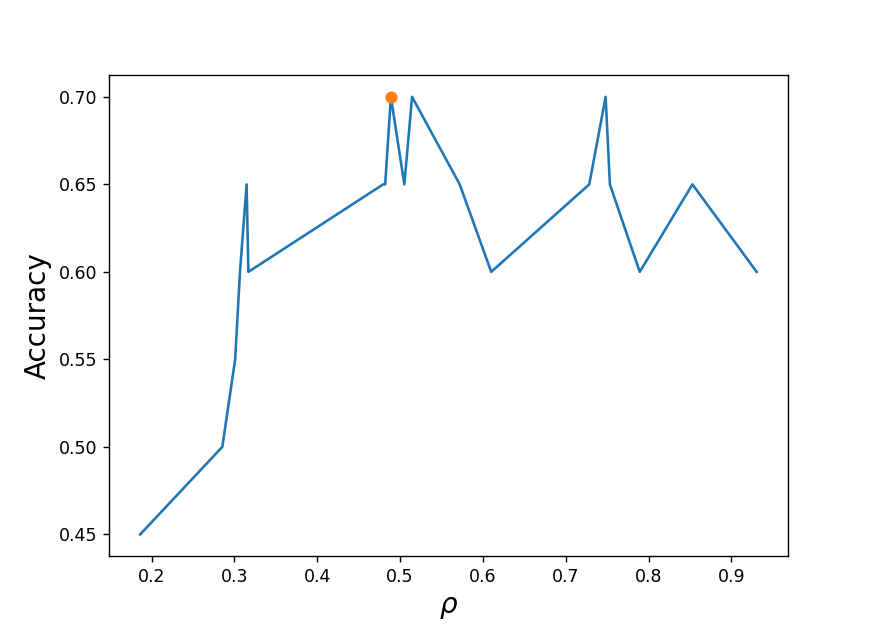

In [16]:
plt.figure(figsize = (7, 5))

plt.plot(Rho, A, rhoA, Abest, 'o')

plt.xlabel(r'$\rho$', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)

plt.show()

# 10. Best threshold for cost

Report the optimal cost and its corresponding probability threshold value.

In [17]:
best_C = np.argmin(Cost)
rhoC = Rho[best_C]
Cbest = Cost[best_C]

# 11. Plot

Plot the cost vs threshold curve and indicate the optimal point with a marker. 

<IPython.core.display.Javascript object>


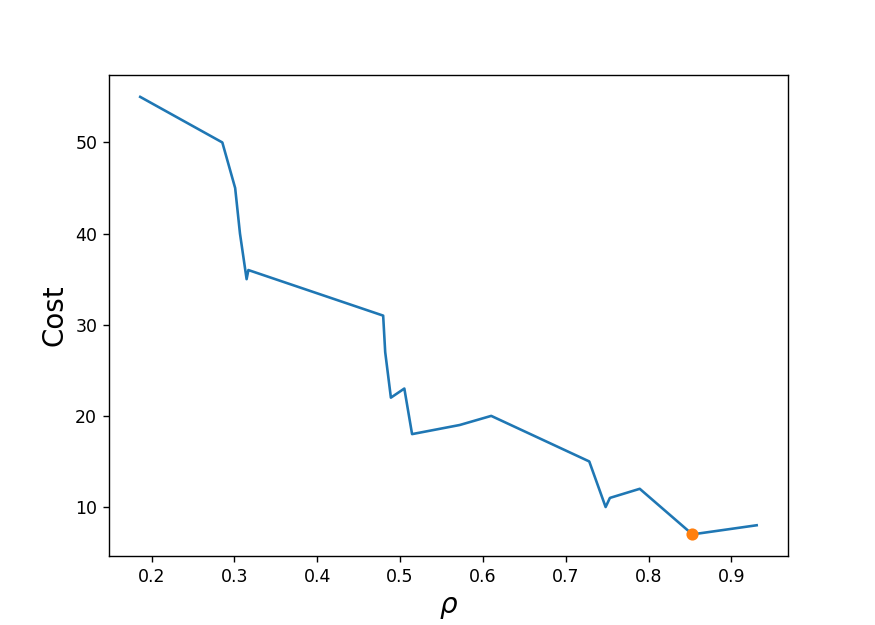

In [18]:
plt.figure(figsize = (7, 5))

plt.plot(Rho, Cost, rhoC, Cbest, 'o')

plt.xlabel(r'$\rho$', fontsize = 16)
plt.ylabel('Cost', fontsize = 16)

plt.show()

# 12. ROC curve

Plot the true positive rate vs the false positive rate. Use the same markers to indicate the optimal accuracy and optimal cost solutions. 

<IPython.core.display.Javascript object>


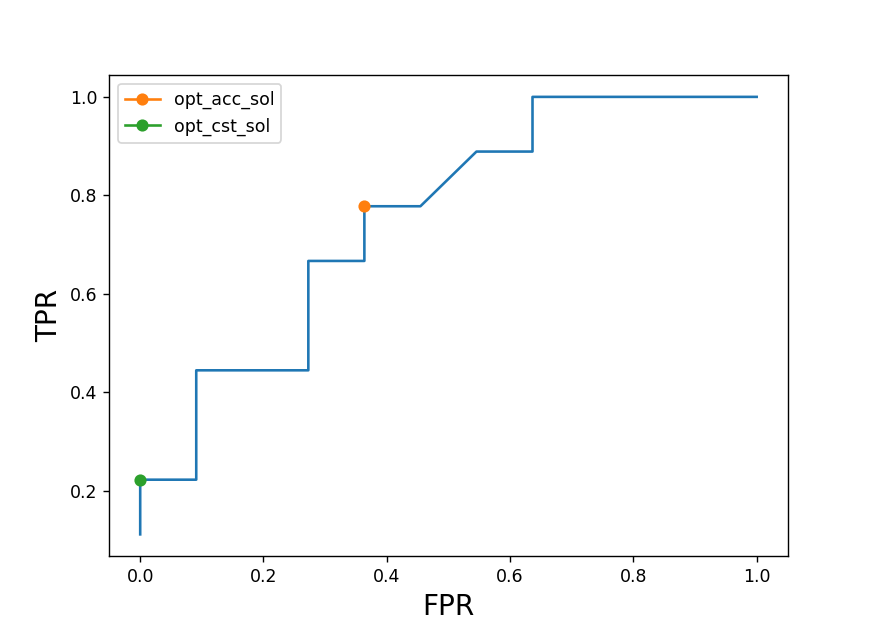

In [19]:
plt.figure(figsize = (7, 5))

plt.plot(1 - TNR, TPR)
plt.plot(1 - TNR[best_A], TPR[best_A], marker = 'o', label = 'opt_acc_sol')
plt.plot(1 - TNR[best_C], TPR[best_C], marker = 'o', label = 'opt_cst_sol')

plt.xlabel('FPR', fontsize = 16)
plt.ylabel('TPR', fontsize = 16)
plt.legend()

plt.show()